<a href="https://colab.research.google.com/github/ylkim1947/Mask_RCNN/blob/master/Outlier_Detection_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

https://www.kaggle.com/arunrk7/surface-crack-detection

In [1]:
#import os
#os.environ['KAGGLE_USERNAME'] = 'kairess' # username
#os.environ['KAGGLE_KEY'] = '' # key

In [2]:
#!kaggle datasets download -d arunrk7/surface-crack-detection

In [3]:
#!unzip -q surface-crack-detection.zip

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install alibi_detect

In [5]:
!pip install alibi-detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 306 kB 4.7 MB/s 
     |████████████████████████████████| 3.4 MB 96.4 MB/s 
     |████████████████████████████████| 5.8 MB 92.0 MB/s 
     |████████████████████████████████| 34.5 MB 1.4 MB/s 
     |████████████████████████████████| 182 kB 101.1 MB/s 
     |████████████████████████████████| 7.6 MB 91.2 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4


# Import Packages

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

# Load Normal Images

- 01-whole: normal images
- 00-damage: crack images

In [7]:
#img_list = glob('/content/drive/MyDrive/Colab Notebooks/project4/car-damage-dataset/data1a/training/01-whole/*.jpg')
img_list = glob('/content/drive/MyDrive/Colab Notebooks/project4/Socar_Hackerthon.v2-socar_hackerthon.yolov5pytorch/train/images/*.jpg')

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2022)

def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths:
      try:
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64*2, 64*2))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

x_train = img_to_np(train_img_list[:1000])
x_train = x_train.astype(np.float32) / 255.

x_val = img_to_np(val_img_list[:32])
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

(1000, 128, 128, 3)
(32, 128, 128, 3)


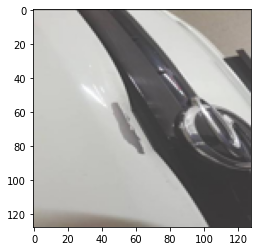

In [8]:
plt.imshow(x_train[0])

# Build Model

In [9]:
## Original

latent_dim = 1024

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),
    Dense(4 * 4 * 128),
    Reshape(target_shape=(4, 4, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

od = OutlierVAE(
    threshold=.5,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

In [10]:
encoder_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
Total params: 1,183,424
Trainable params: 1,183,424
Non-trainable params: 0
_________________________________________________________________


In [11]:
decoder_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        524544    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       262208    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       32800     
 ranspose)                                                       
                                                      

In [12]:
## modified version

latent_dim = 1024*2

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64*2, 64*2, 3)),
    Conv2D(64*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(1024*2, 4, strides=2, padding='same', activation=tf.nn.relu),

])

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),
    Dense(4 * 4 * 128 *4),
    Reshape(target_shape=(4, 4, 128*4)),
    Conv2DTranspose(512*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(256*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32*2, 4, strides=2, padding='same', activation=tf.nn.relu),
   # Conv2DTranspose(3*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

od = OutlierVAE(
    threshold=.05,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

In [13]:
encoder_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       6272      
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       524544    
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 1024)      4195328   
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 2048)        33556480  
                                                                 
Total params: 38,282,624
Trainable params: 38,282,624
Non-trainable params: 0
_________________________________________________________________


In [14]:
decoder_net.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              16785408  
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 1024)       8389632   
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 512)      8389120   
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 32, 32, 128)      1048704   
 ranspose)                                                       
                                                      

# Train

In [15]:
od.fit(
    x_train,
    epochs=300,
    verbose=True
)

16/16 [=] - 1s 81ms/step - loss_ma: -90846.0853


# Reconstruct Training Image

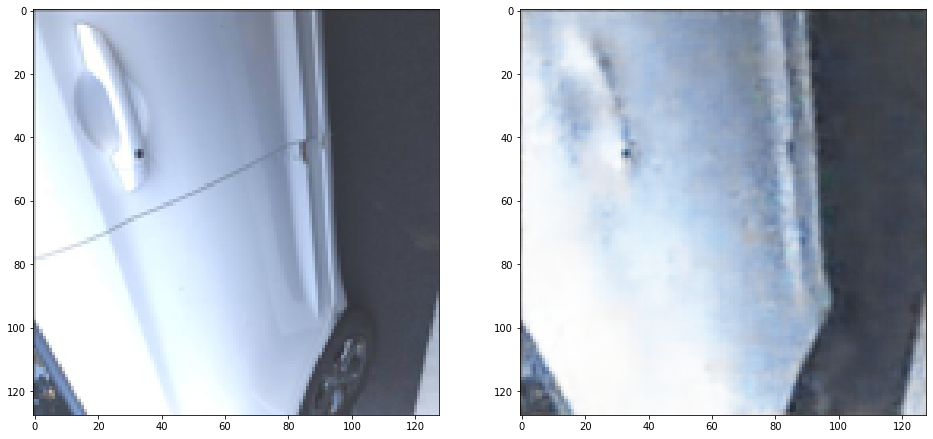

In [16]:
idx = 32
x = x_train[idx].reshape(1, 128, 128, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

# Validation

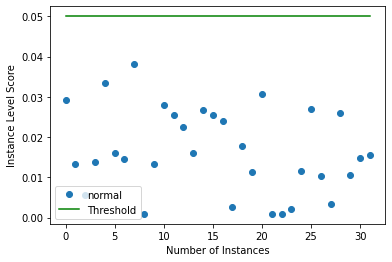

In [17]:
od_preds = od.predict(
    x_val,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

# Reconstruct Validation Images

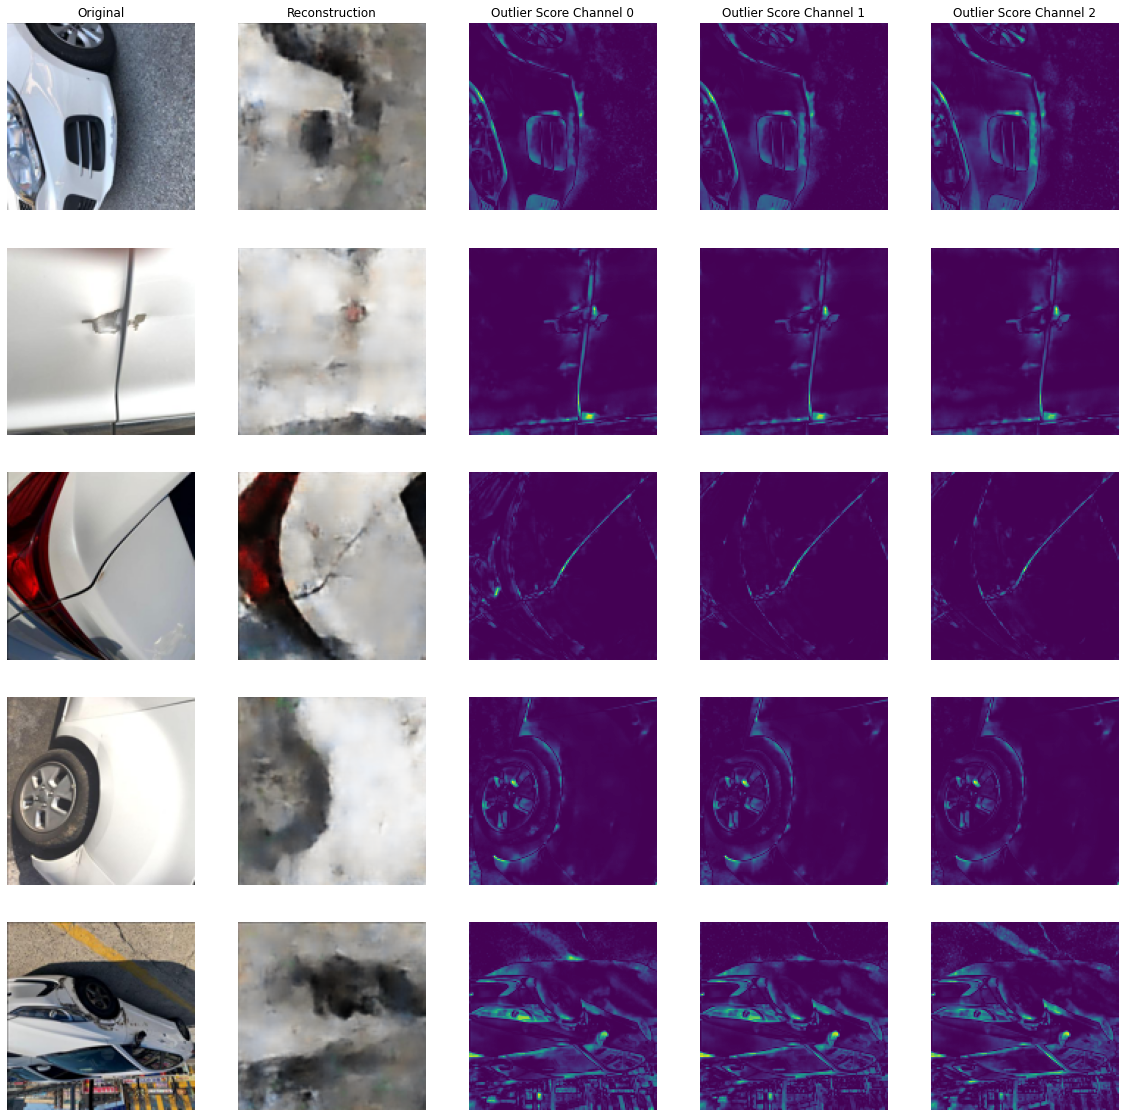

In [18]:
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

# Outliers

In [19]:
plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

<Figure size 1440x1440 with 0 Axes>

# Test with Crack Images

In [20]:
test_img_list = glob('/content/drive/MyDrive/Colab Notebooks/project4/car-damage-dataset/data1a/training/00-damage/*.jpeg')

x_test = img_to_np(test_img_list[:32])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(32, 128, 128, 3)


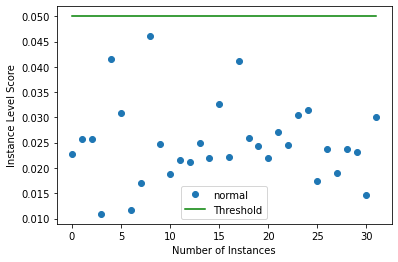

In [21]:
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

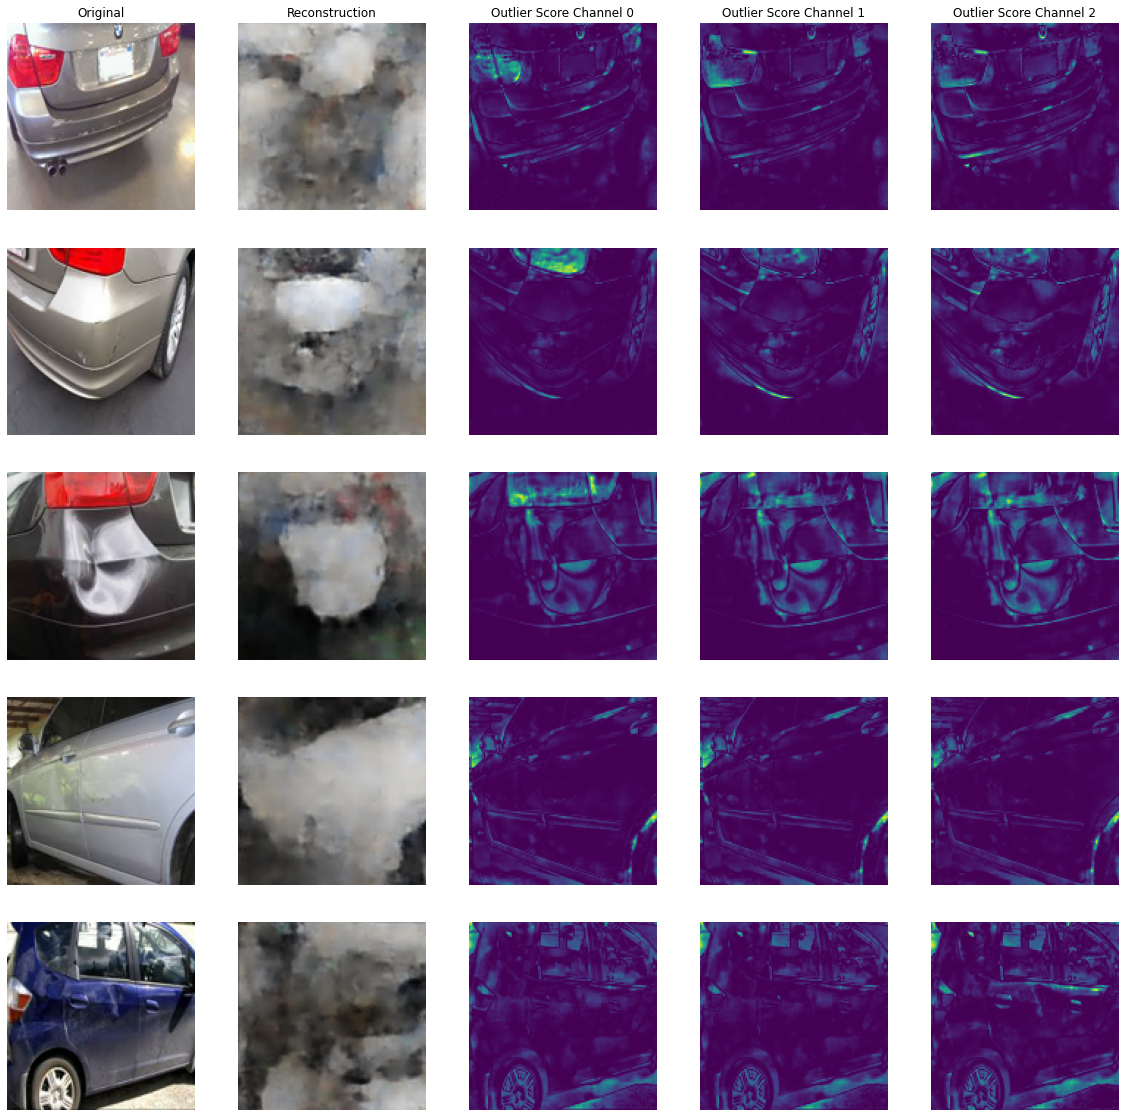

In [22]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)